## Import Python libraries
---
Start by `pip install -U -r requirements.txt --user `

In [ ]:
#! pip install -U -r requirements.txt

In [18]:
!pip install meteostat

     |████████████████████████████████| 17.7MB 23.4MB/s 
  Created wheel for meteostat: filename=meteostat-1.0.0-cp36-none-any.whl size=12227 sha256=292c6caa44c8a8625236f9539cb0dd3980c77e2ecc0c45dc3dd1365b3ce6d869
  Stored in directory: /root/.cache/pip/wheels/ee/af/ae/17e629c6bc3d1bcbe07971577041dcdbbc65f5046e3c28c875
Successfully built meteostat
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [19]:
import pandas as pd
import numpy as np
import random
from scipy.stats import pearsonr
import datetime
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta

# Graphics
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 20000)
pd.set_option('display.width', 10000)

# Temp
from meteostat import Stations, Daily
from geopy.geocoders import Nominatim
from itertools import product
geolocator = Nominatim(user_agent='myapplication')

path = '../data/'

In [20]:
# Graphical Parameters from Matplotlib
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.rcParams['figure.figsize'] = [40, 15]
plt.rcParams['figure.dpi'] = 75 # 200 e.g. is really fine, but slower
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

## Data Engineering
---

In [1]:
!pip install osfclient

In [5]:
!python download_data.py

100% 72.2k/72.2k [00:00<00:00, 48.8Mbytes/s]
100% 381M/381M [00:01<00:00, 195Mbytes/s]
100% 627/627 [00:00<00:00, 3.68Mbytes/s]
100% 13.2k/13.2k [00:00<00:00, 29.9Mbytes/s]
100% 14.6k/14.6k [00:00<00:00, 27.7Mbytes/s]
100% 42.6k/42.6k [00:00<00:00, 67.2Mbytes/s]
100% 42.7k/42.7k [00:00<00:00, 50.0Mbytes/s]
100% 14.4k/14.4k [00:00<00:00, 37.7Mbytes/s]
100% 804k/804k [00:00<00:00, 158Mbytes/s]
100% 56.1k/56.1k [00:00<00:00, 62.5Mbytes/s]
100% 795k/795k [00:00<00:00, 156Mbytes/s]
100% 191k/191k [00:00<00:00, 122Mbytes/s]
100% 189k/189k [00:00<00:00, 114Mbytes/s]
100% 13.6k/13.6k [00:00<00:00, 31.6Mbytes/s]
100% 1.84G/1.84G [00:09<00:00, 188Mbytes/s]
100% 30.4M/30.4M [00:00<00:00, 114Mbytes/s] 
saved 16 files to data


### Preprocessing

In [26]:
path = 'data/'

In [11]:
# Read the CSV file, delete unnamed columns, creates load factor, keeps only number of seats > 10, creates DATE column
def read_n_clean(name):
  df = pd.read_csv(name)
  # Drop Unnamed Columns
  df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis = 1, inplace = True)
  df['DATE'] =  pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
  # We pick only data from 2013 to 2019
  date_ref1 = datetime.datetime(2013, 1, 1)
  date_ref2 = datetime.datetime(2020, 1, 1)
  df = df[(df['DATE'] >= date_ref1) & (df['DATE'] < date_ref2)]
  # We pick only flights with available seats > 10
  df = df[df["SEATS"] > 10].reset_index(drop=True)  
  # We pick only flights with non-null distance travelled 
  df = df[df["DISTANCE"] > 0].reset_index(drop=True) 
  # We dropped the Hageland Airline data -> the company has shut down since 2008 and has very low amounts of tweets
  df = df[df['UNIQUE_CARRIER'] != "H6"]
  # We dropped the US Airways as the company stopped since 2015
  df = df[df['UNIQUE_CARRIER_NAME'] != 'US Airways Inc.']
  # Load-Factor Creation
  df["RPM"] = df["PASSENGERS"] * df["DISTANCE"]
  df["ASM"] = df["SEATS"] * df["DISTANCE"]
  return df

In [12]:
df = read_n_clean(path + "T_100_Domestic_Segment_All_Years_Extended.csv")
df.head()

,DEPARTURES_SCHEDULED,DEPARTURES_PERFORMED,PAYLOAD,SEATS,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER,AIRLINE_ID,UNIQUE_CARRIER_NAME,CARRIER_NAME,CARRIER_GROUP,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,AIRCRAFT_GROUP,AIRCRAFT_TYPE,AIRCRAFT_CONFIG,YEAR,MONTH,DISTANCE_GROUP,CLASS,DATE,RPM,ASM
0,0.0,1.0,22900.0,88.0,68.0,0.0,0.0,1149.0,CP,21167.0,Compass Airlines,Compass Airlines,2,10423,AUS,"Austin, TX",TX,11433,DTW,"Detroit, MI",MI,6,677,1,2015,3,3,F,2015-03-01,78132.0,101112.0
1,0.0,9.0,206100.0,792.0,430.0,0.0,0.0,1042.0,CP,21167.0,Compass Airlines,Compass Airlines,2,10423,AUS,"Austin, TX",TX,13487,MSP,"Minneapolis, MN",MN,6,677,1,2015,3,3,F,2015-03-01,448060.0,825264.0
2,0.0,1.0,22900.0,88.0,69.0,0.0,0.0,748.0,CP,21167.0,Compass Airlines,Compass Airlines,2,10620,BIL,"Billings, MT",MT,13487,MSP,"Minneapolis, MN",MN,6,677,1,2015,3,2,F,2015-03-01,51612.0,65824.0
3,0.0,1.0,21850.0,86.0,27.0,0.0,0.0,386.0,CP,21167.0,Compass Airlines,Compass Airlines,2,10627,BIS,"Bismarck/Mandan, ND",ND,13487,MSP,"Minneapolis, MN",MN,6,673,1,2015,3,1,F,2015-03-01,10422.0,33196.0
4,0.0,1.0,22900.0,88.0,64.0,0.0,0.0,500.0,CP,21167.0,Compass Airlines,Compass Airlines,2,11057,CLT,"Charlotte, NC",NC,11433,DTW,"Detroit, MI",MI,6,677,1,2015,3,2,F,2015-03-01,32000.0,44000.0


### Airlines Global Performance - Choosing the best relevant airlines

In [13]:
# MOY FLIGHTS
count_flights = df.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['PASSENGERS'].count().reset_index(name = 'NB_FLIGHTS')
count_flights_f = count_flights.groupby(['UNIQUE_CARRIER_NAME'])['NB_FLIGHTS'].mean().reset_index(name = 'MOY_NB_FLIGHTS').sort_values('MOY_NB_FLIGHTS', ascending = False)
# TOT Passengers
tot_pass = count_flights_f.merge(df.groupby(['UNIQUE_CARRIER_NAME'])['PASSENGERS'].sum().reset_index(name = 'TOT_PASS_FLIGHTS').reset_index(drop=True), on= ['UNIQUE_CARRIER_NAME']).sort_values('TOT_PASS_FLIGHTS', ascending = False)
# NB Flights
tot_nb_flights = tot_pass.merge(df.groupby(['UNIQUE_CARRIER_NAME'])['PASSENGERS'].count().reset_index(name = 'TOT_NB_FLIGHTS').reset_index(drop=True), on=['UNIQUE_CARRIER_NAME']).sort_values('TOT_NB_FLIGHTS', ascending = False)

In [14]:
copy = tot_nb_flights.copy()
scaler = StandardScaler()
copy.iloc[:, 1:] = scaler.fit_transform(copy.iloc[:, 1:])
copy['TOTAL'] = copy['MOY_NB_FLIGHTS'] + copy['TOT_PASS_FLIGHTS'] + copy['TOT_NB_FLIGHTS']
copy.sort_values('TOTAL', ascending=False, inplace=True)
copy.head()

,UNIQUE_CARRIER_NAME,MOY_NB_FLIGHTS,TOT_PASS_FLIGHTS,TOT_NB_FLIGHTS,TOTAL
0,Southwest Airlines Co.,5.735498,7.138406,5.742586,18.616490
1,Delta Air Lines Inc.,5.385813,5.608211,5.393859,16.387883
3,United Air Lines Inc.,4.587956,3.503712,4.598185,12.689853
2,American Airlines Inc.,2.522438,4.762726,2.538320,9.823484
4,SkyWest Airlines Inc.,3.602894,1.305467,3.615820,8.524181


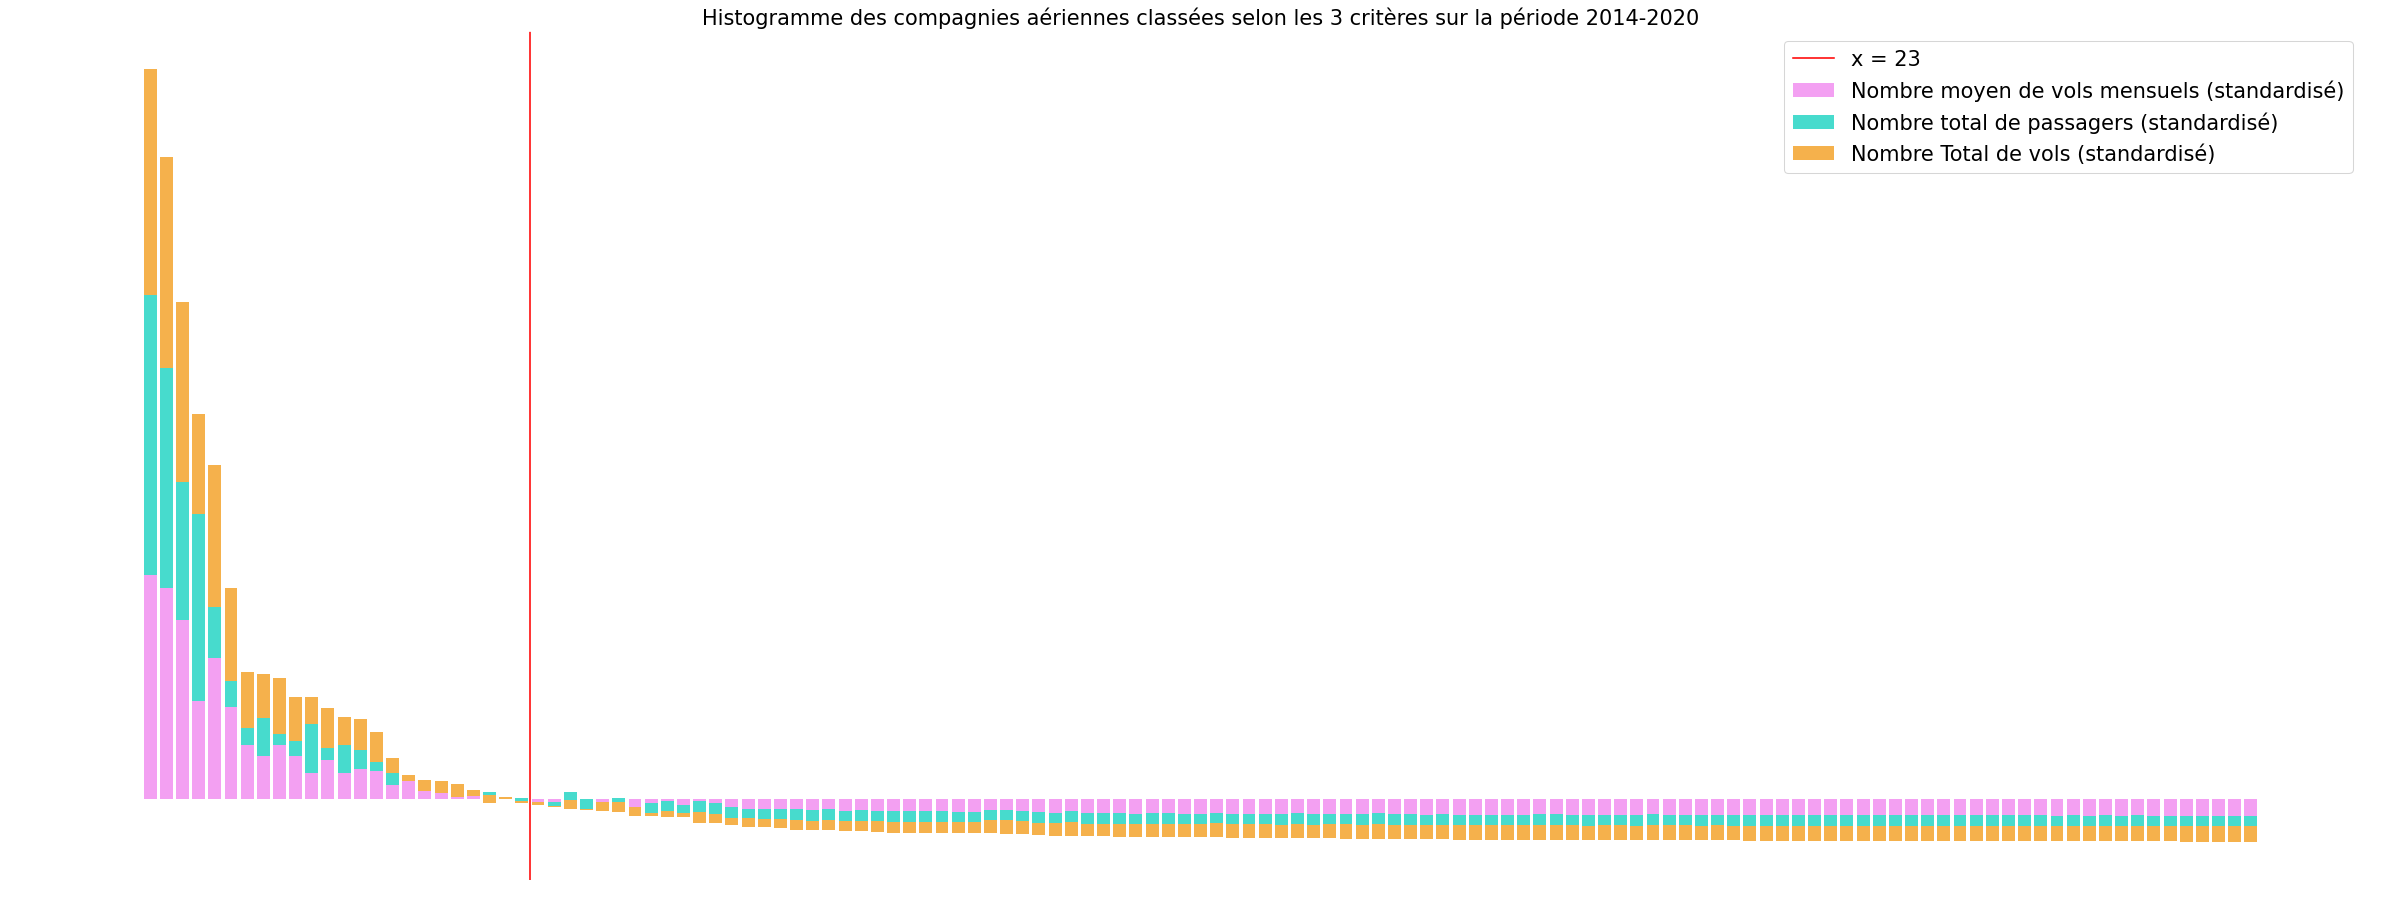

In [21]:
copy.sort_values('TOTAL', inplace=True, ascending = False)
plt.bar(copy['UNIQUE_CARRIER_NAME'], copy['MOY_NB_FLIGHTS'], color = 'C1', label = 'Nombre moyen de vols mensuels (standardisé)')
plt.bar(copy['UNIQUE_CARRIER_NAME'], copy['TOT_PASS_FLIGHTS'], bottom = copy['MOY_NB_FLIGHTS'], color = 'C2', label = 'Nombre total de passagers (standardisé)')
plt.bar(copy['UNIQUE_CARRIER_NAME'], copy['TOT_NB_FLIGHTS'], bottom = copy['MOY_NB_FLIGHTS'] + copy['TOT_PASS_FLIGHTS'], color = 'C3', label = 'Nombre Total de vols (standardisé)')
plt.axvline(x=23.5, color='r', linestyle='-', label = 'x = 23')
plt.legend(prop={'size': 20})
plt.title("Histogramme des compagnies aériennes classées selon les 3 critères sur la période 2014-2020", fontsize = 20)
plt.show()

In [22]:
carriers_f = copy.iloc[:21, :].reset_index(drop=True)['UNIQUE_CARRIER_NAME'].to_numpy().tolist()
print("List of Carriers to use :")
print('------------------------------')
print(*carriers_f,sep='\n')

List of Carriers to use :
------------------------------
Southwest Airlines Co.
Delta Air Lines Inc.
United Air Lines Inc.
American Airlines Inc.
SkyWest Airlines Inc.
ExpressJet Airlines LLC
Republic Airline
Alaska Airlines Inc.
Allegiant Air
Envoy Air
JetBlue Airways
Endeavor Air Inc.
Spirit Air Lines
Frontier Airlines Inc.
PSA Airlines Inc.
Mesa Airlines Inc.
Shuttle America Corp.
GoJet Airlines LLC d/b/a United Express
Sun Country Airlines d/b/a MN Airlines
Grant Aviation
Air Wisconsin Airlines Corp


In [33]:
df = df[df['UNIQUE_CARRIER_NAME'].isin(carriers_f)].sort_values('DISTANCE')
df

,DEPARTURES_SCHEDULED,DEPARTURES_PERFORMED,PAYLOAD,SEATS,PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER,AIRLINE_ID,UNIQUE_CARRIER_NAME,CARRIER_NAME,CARRIER_GROUP,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,AIRCRAFT_GROUP,AIRCRAFT_TYPE,AIRCRAFT_CONFIG,YEAR,MONTH,DISTANCE_GROUP,CLASS,DATE,RPM,ASM
182011,0.0,2.0,2000.0,12.0,4.0,0.0,0.0,3.0,GV,20455.0,Grant Aviation,Grant Aviation,1,10770,A2K,"Bartletts, AK",AK,11511,EGX,"Egegik, AK",AK,0,35,1,2016,7,1,F,2016-07-01,12.0,36.0
248606,0.0,9.0,25200.0,81.0,15.0,13.0,1616.0,3.0,GV,20455.0,Grant Aviation,Grant Aviation,1,10770,A2K,"Bartletts, AK",AK,11511,EGX,"Egegik, AK",AK,4,416,1,2015,7,1,F,2015-07-01,45.0,243.0
61223,0.0,3.0,3000.0,18.0,3.0,0.0,2.0,3.0,GV,20455.0,Grant Aviation,Grant Aviation,1,10770,A2K,"Bartletts, AK",AK,11511,EGX,"Egegik, AK",AK,0,35,1,2016,6,1,F,2016-06-01,9.0,54.0
352208,0.0,1.0,98335.0,293.0,0.0,0.0,0.0,3.0,DL,19790.0,Delta Air Lines Inc.,Delta Air Lines Inc.,3,14679,SAN,"San Diego, CA",CA,13791,NZY,"San Diego, CA",CA,6,687,1,2014,12,1,L,2014-12-01,0.0,879.0
61357,0.0,13.0,31400.0,117.0,28.0,96.0,69.0,3.0,GV,20455.0,Grant Aviation,Grant Aviation,1,11511,EGX,"Egegik, AK",AK,10770,A2K,"Bartletts, AK",AK,4,416,1,2016,6,1,F,2016-06-01,84.0,351.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688875,2.0,2.0,179160.0,490.0,407.0,4832.0,1482.0,4983.0,DL,19790.0,Delta Air Lines Inc.,Delta Air Lines Inc.,3,12478,JFK,"New York, NY",NY,12173,HNL,"Honolulu, HI",HI,6,624,1,2015,1,10,F,2015-01-01,2028081.0,2441670.0
1088909,11.0,11.0,1015660.0,2678.0,2066.0,95635.0,8327.0,4983.0,DL,19790.0,Delta Air Lines Inc.,Delta Air Lines Inc.,3,12173,HNL,"Honolulu, HI",HI,12478,JFK,"New York, NY",NY,6,624,1,2017,12,10,F,2017-12-01,10294878.0,13344474.0
1160962,15.0,15.0,1395940.0,3674.0,2926.0,106165.0,28804.0,4983.0,DL,19790.0,Delta Air Lines Inc.,Delta Air Lines Inc.,3,12173,HNL,"Honolulu, HI",HI,12478,JFK,"New York, NY",NY,6,624,1,2016,12,10,F,2016-12-01,14580258.0,18307542.0
1277829,23.0,23.0,2118990.0,5636.0,4843.0,248239.0,61909.0,4983.0,DL,19790.0,Delta Air Lines Inc.,Delta Air Lines Inc.,3,12173,HNL,"Honolulu, HI",HI,12478,JFK,"New York, NY",NY,6,624,1,2017,1,10,F,2017-01-01,24132669.0,28084188.0


### Calculate Load Factor

In [34]:
def extract_monthly_load_factor(data):
  tmp = data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])["RPM"].sum().reset_index(name="RPM_SUM")
  tmp2 = data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])["ASM"].sum().reset_index(name="ASM_SUM")
  merged = tmp.merge(tmp2, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  merged["LOAD_FACTOR"] = merged["RPM_SUM"]/merged["ASM_SUM"]
  merged.drop(columns=['RPM_SUM', 'ASM_SUM'], inplace=True)
  return merged

In [35]:
load_factor_data = extract_monthly_load_factor(df)
load_factor_data.head()

,UNIQUE_CARRIER_NAME,DATE,LOAD_FACTOR
0,Air Wisconsin Airlines Corp,2013-01-01,0.694164
1,Air Wisconsin Airlines Corp,2013-02-01,0.733276
2,Air Wisconsin Airlines Corp,2013-03-01,0.746661
3,Air Wisconsin Airlines Corp,2013-04-01,0.774147
4,Air Wisconsin Airlines Corp,2013-05-01,0.774738


## Add Some General Statistics
---
- Fuel price
- PMI factor
- Unemployment rate

In [36]:
fuel_price_barrel = pd.read_excel(path + "Other/wti.xlsx")
fuel_price_barrel['Date'] = pd.to_datetime(fuel_price_barrel['Date']).apply(lambda x: x.replace(day=1))
fuel_price_barrel.rename(columns={'Close(CLc1)': 'Price', 'Date': 'DATE'}, inplace=True)
fuel_price_barrel.head()

,DATE,Price
0,2020-12-01,48.42
1,2020-11-01,45.06
2,2020-10-01,35.72
3,2020-09-01,39.86
4,2020-08-01,42.82


In [37]:
PMI_data = pd.read_excel(path + 'Other/Economic-Indicator_United-States-ISM-Manufacturing-PMI_2-Jan-2021.xlsx', sheet_name='First Release Data', header = 3)
PMI_data.drop(index=0, inplace=True)
PMI_data['Original Release Date'] = pd.to_datetime(PMI_data['Original Release Date']).apply(lambda x: x.replace(day=1))
PMI_data['Original Release Date'] = [d.date() for d in PMI_data['Original Release Date']]
PMI_data.rename(columns={'Original Release Date' : 'DATE', 'First Release': 'PMI'}, inplace=True)
PMI_data.drop(columns=['Period'], inplace=True)
PMI_data.head()

,DATE,PMI
1,2020-12-01,57.5
2,2020-11-01,59.3
3,2020-10-01,55.4
4,2020-09-01,56.0
5,2020-08-01,54.2


In [38]:
unemployment_data = pd.read_excel(path + 'Other/Economic-Indicator_United-States-Unemployment-Rate__2-Jan-2021.xlsx', sheet_name='First Release Data', header = 3)
unemployment_data.drop(index=0, inplace=True)
unemployment_data['Original Release Date'] = pd.to_datetime(unemployment_data['Original Release Date']).apply(lambda x: x.replace(day=1))
unemployment_data['Original Release Date'] = [d.date() for d in unemployment_data['Original Release Date']]
unemployment_data.drop(columns=['Period'], inplace=True)
unemployment_data.rename(columns={'Original Release Date': 'DATE', 'First Release': 'UNEMPLOYMENT'}, inplace=True)
unemployment_data.head()

,DATE,UNEMPLOYMENT
1,2020-12-01,6.7%
2,2020-11-01,6.9%
3,2020-10-01,7.9%
4,2020-09-01,8.4%
5,2020-08-01,10.2%


## Features Engineering
---
### Features Distance Group

In [39]:
def get_distance_features(data):
  '''EXTRACTS DISTANCE GROUP FREQ FEATURES'''
  # Count the flights by distance group by data by company
  distances = data.groupby(['UNIQUE_CARRIER_NAME', 'DISTANCE_GROUP', 'DATE'])['DISTANCE_GROUP'].count().reset_index(name="count")
  # Get total of all distance groups by date by company
  distances_2 = distances.groupby(['DATE', 'UNIQUE_CARRIER_NAME'])['count'].sum().reset_index(name='TOTAL')
  # Create Frequency column
  distances = distances.merge(distances_2, 'outer', on=['DATE', 'UNIQUE_CARRIER_NAME'])
  distances['FREQ'] = distances['count']/(distances['TOTAL'])
  distances.sort_values(['DISTANCE_GROUP', 'DATE']).reset_index(drop=True)
  # Simplify dataset (to set as comment if you want on final dataset)
  final_dataset = distances.drop(columns=['count', 'TOTAL'])
  # Create the features and populate the final dataframe
  dataframe = pd.DataFrame(columns=['UNIQUE_CARRIER_NAME', 'DATE', 'DG_1', 'DG_2', 'DG_3', 'DG_4', 'DG_5'])
  unique_carriers = np.unique(final_dataset['UNIQUE_CARRIER_NAME'])
  DG = []
  for carrier in tqdm(unique_carriers):
    dates = np.unique(final_dataset[final_dataset['UNIQUE_CARRIER_NAME']== carrier]['DATE'])
    for date in dates:
      for i in range(1, 6):
        tmp = final_dataset[(final_dataset['UNIQUE_CARRIER_NAME']== carrier) & (final_dataset['DATE'] == date) & (final_dataset['DISTANCE_GROUP'] == i)]['FREQ'].values
        if len(tmp) == 0:
          DG.append(0)
        else:
          DG.append(np.round(tmp[0], 3))
      tmp = [carrier, date, DG[0], DG[1], DG[2], DG[3], DG[4]]
      df_length = len(dataframe)
      dataframe.loc[df_length] = tmp
      DG = []
  return dataframe

In [40]:
distance_features = get_distance_features(df)
distance_features.head()

,UNIQUE_CARRIER_NAME,DATE,DG_1,DG_2,DG_3,DG_4,DG_5
0,Air Wisconsin Airlines Corp,2013-01-01,0.743,0.251,0.006,0,0
1,Air Wisconsin Airlines Corp,2013-02-01,0.723,0.266,0.011,0,0
2,Air Wisconsin Airlines Corp,2013-03-01,0.740,0.253,0.007,0,0
3,Air Wisconsin Airlines Corp,2013-04-01,0.741,0.253,0.007,0,0
4,Air Wisconsin Airlines Corp,2013-05-01,0.728,0.265,0.006,0,0


In [46]:
distance_features.to_csv("distance_features.csv")

### Features Aircraft Type Frequency

In [41]:
aircraft_type_freq = df.groupby(['UNIQUE_CARRIER_NAME', 'DATE', 'AIRCRAFT_TYPE'])['AIRCRAFT_TYPE'].count().reset_index(name='COUNT')
ref = df.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['AIRCRAFT_TYPE'].count().reset_index(name='TOTAL')
final = aircraft_type_freq.merge(ref, on=['UNIQUE_CARRIER_NAME', 'DATE'])
final['FREQ'] = final['COUNT'] / final['TOTAL']
final.head()

,UNIQUE_CARRIER_NAME,DATE,AIRCRAFT_TYPE,COUNT,TOTAL,FREQ
0,Air Wisconsin Airlines Corp,2013-01-01,629,315,315,1.0
1,Air Wisconsin Airlines Corp,2013-02-01,629,278,278,1.0
2,Air Wisconsin Airlines Corp,2013-03-01,629,269,269,1.0
3,Air Wisconsin Airlines Corp,2013-04-01,629,297,297,1.0
4,Air Wisconsin Airlines Corp,2013-05-01,629,309,309,1.0


In [42]:
aircraft_types = np.unique(final['AIRCRAFT_TYPE'])
dataframe = pd.DataFrame(columns=aircraft_types)
dataframe['UNIQUE_CARRIER_NAME'] = np.nan
dataframe['DATE'] = np.nan
cols = dataframe.columns.tolist()
cols = cols[-2:] + cols[:-2]
dataframe = dataframe[cols]
unique_carriers = np.unique(final['UNIQUE_CARRIER_NAME'])
AT = []
for carrier in tqdm(unique_carriers):
  dates = np.unique(final[final['UNIQUE_CARRIER_NAME']== carrier]['DATE'])
  for date in dates:
    for aircraft_type in aircraft_types:
      tmp = final[(final['UNIQUE_CARRIER_NAME']== carrier) & (final['DATE'] == date) & (final['AIRCRAFT_TYPE'] == aircraft_type)]['FREQ'].values
      if len(tmp) == 0:
        AT.append(0)
      else:
        AT.append(np.round(tmp[0], 3))
    tmp = np.append([carrier, date], AT)
    df_length = len(dataframe)
    dataframe.loc[df_length] = tmp
    AT = []

In [43]:
dataframe['DATE'] = pd.to_datetime(dataframe['DATE'])
dataframe.head()

,UNIQUE_CARRIER_NAME,DATE,26,35,194,339,359,406,416,461,482,530,608,612,614,616,617,619,622,623,624,625,626,627,629,631,634,637,638,644,650,654,655,656,673,674,675,676,677,678,687,694,696,698,699,721,722,723,819,822,837,838,839,887,888,889
0,Air Wisconsin Airlines Corp,2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Air Wisconsin Airlines Corp,2013-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Air Wisconsin Airlines Corp,2013-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Air Wisconsin Airlines Corp,2013-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Air Wisconsin Airlines Corp,2013-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
dataframe.to_csv("aircraft_type_frequency_features.csv")

### Features Geographic Destination

#### TOP 1 Destination per Airline

In [47]:
def get_top1_dest(data):
  test_geo = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE', 'DEST_CITY_NAME'])['DEST_CITY_NAME'].count().reset_index(name="DEST_COUNT")).reset_index(drop=True).drop_duplicates(['UNIQUE_CARRIER_NAME', 'DATE','DEST_COUNT'])
  test_geo_2 = pd.DataFrame(test_geo.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['DEST_COUNT'].max()).reset_index(drop=False)
  test_geo_top = test_geo.merge(test_geo_2, 'inner', on=['UNIQUE_CARRIER_NAME', 'DATE', 'DEST_COUNT'])
  test_geo_tot = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['DEST_CITY_NAME'].count().reset_index(name="TOTAL")).reset_index(drop=True)
  test_geo_fq_top = test_geo_top.merge(test_geo_tot, 'inner', on=['UNIQUE_CARRIER_NAME', 'DATE'])
  test_geo_fq_top['FREQ'] = test_geo_fq_top['DEST_COUNT']/test_geo_fq_top['TOTAL']
  test_geo_fq_top = test_geo_fq_top.rename(columns = {'DEST_CITY_NAME' : 'TOP1_DEST', 'FREQ': 'TOP_1_DEST_FQ'}).drop(columns=['DEST_COUNT', 'TOTAL'])
  return test_geo_fq_top

In [48]:
top1_dest_features = get_top1_dest(df)
top1_dest_features.head()

,UNIQUE_CARRIER_NAME,DATE,TOP1_DEST,TOP_1_DEST_FQ
0,Air Wisconsin Airlines Corp,2013-01-01,"Charlotte, NC",0.155556
1,Air Wisconsin Airlines Corp,2013-02-01,"Philadelphia, PA",0.165468
2,Air Wisconsin Airlines Corp,2013-03-01,"Charlotte, NC",0.167286
3,Air Wisconsin Airlines Corp,2013-04-01,"Philadelphia, PA",0.161616
4,Air Wisconsin Airlines Corp,2013-05-01,"Washington, DC",0.155340


In [49]:
top1_dest_features.to_csv("top1_dest_features.csv")

#### TOP 5 DESTINATIONS 

In [50]:
def get_top5_dest(data):
  test_geo_top5 = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE', 'DEST_CITY_NAME'])['DEST_CITY_NAME'].count().reset_index(name="DEST_COUNT")).reset_index(drop=True)
  test_geo_top5.sort_values(['UNIQUE_CARRIER_NAME', 'DATE','DEST_COUNT'], inplace=True, ascending=False)
  test_geo_top5 = test_geo_top5.sort_values(['UNIQUE_CARRIER_NAME', 'DATE']).set_index(['UNIQUE_CARRIER_NAME', 'DATE']).reset_index()
  carriers = np.unique(test_geo_top5['UNIQUE_CARRIER_NAME'])

  top5dest_data = pd.DataFrame(columns=['UNIQUE_CARRIER_NAME', 'DATE', 'TOP1_DEST', 'TOP2_DEST', 'TOP3_DEST', 'TOP4_DEST', 'TOP5_DEST'])
  for carrier in tqdm(carriers):
    dates = np.unique(test_geo_top5[test_geo_top5['UNIQUE_CARRIER_NAME']== carrier]['DATE'])
    max_location = []
    max_value = []
    for date in dates:
        max_location = test_geo_top5[(test_geo_top5['UNIQUE_CARRIER_NAME']== carrier) & (test_geo_top5['DATE'] == date)]['DEST_CITY_NAME'].values[0:5]
        max_value = test_geo_top5[(test_geo_top5['UNIQUE_CARRIER_NAME']== carrier) & (test_geo_top5['DATE'] == date)]['DEST_COUNT'].values[0:5]
        while len(max_location) < 5:
          max_location = np.append(max_location, None)
        tmp = [carrier, date, max_location[0],  max_location[1],  max_location[2],  max_location[3],  max_location[4]]
        df_length = len(top5dest_data)
        top5dest_data.loc[df_length] = tmp
  return top5dest_data

In [64]:
top5_dest_features = get_top5_dest(df)
top5_dest_features.head()



  0%|          | 0/21 [00:00<?, ?it/s]

  5%|▍         | 1/21 [00:02<00:45,  2.27s/it]

 10%|▉         | 2/21 [00:04<00:43,  2.28s/it]

 14%|█▍        | 3/21 [00:06<00:41,  2.28s/it]

 19%|█▉        | 4/21 [00:09<00:38,  2.29s/it]

 24%|██▍       | 5/21 [00:11<00:36,  2.29s/it]

 29%|██▊       | 6/21 [00:13<00:34,  2.29s/it]

 33%|███▎      | 7/21 [00:16<00:32,  2.30s/it]

 38%|███▊      | 8/21 [00:18<00:29,  2.29s/it]

 43%|████▎     | 9/21 [00:20<00:27,  2.29s/it]

 48%|████▊     | 10/21 [00:22<00:25,  2.29s/it]

 52%|█████▏    | 11/21 [00:25<00:22,  2.29s/it]

 57%|█████▋    | 12/21 [00:27<00:20,  2.29s/it]

 62%|██████▏   | 13/21 [00:29<00:18,  2.28s/it]

 67%|██████▋   | 14/21 [00:32<00:16,  2.29s/it]

 71%|███████▏  | 15/21 [00:34<00:13,  2.28s/it]

 76%|███████▌  | 16/21 [00:35<00:10,  2.00s/it]

 81%|████████  | 17/21 [00:37<00:08,  2.09s/it]

 86%|████████▌ | 18/21 [00:40<00:06,  2.16s/it]

 90%|█████████ | 19/21 [00:42<00:04,  2.21s/it]

 95%|█████████▌| 20/21 [00:44<00:02,

,UNIQUE_CARRIER_NAME,DATE,TOP1_DEST,TOP2_DEST,TOP3_DEST,TOP4_DEST,TOP5_DEST
0,Air Wisconsin Airlines Corp,2013-01-01,"Charlotte, NC","Philadelphia, PA","Washington, DC","Boston, MA","Scranton/Wilkes-Barre, PA"
1,Air Wisconsin Airlines Corp,2013-02-01,"Philadelphia, PA","Charlotte, NC","Washington, DC","Greer, SC","Boston, MA"
2,Air Wisconsin Airlines Corp,2013-03-01,"Charlotte, NC","Philadelphia, PA","Washington, DC","Boston, MA","Buffalo, NY"
3,Air Wisconsin Airlines Corp,2013-04-01,"Philadelphia, PA","Washington, DC","Charlotte, NC","Boston, MA","Buffalo, NY"
4,Air Wisconsin Airlines Corp,2013-05-01,"Washington, DC","Charlotte, NC","Philadelphia, PA","Baltimore, MD","Boston, MA"


In [65]:
top5_dest_features.to_csv("top5_dest_features.csv")

#### TOP 5 DESTINATIONS With Weather features

In [ ]:
#!python weather_data.py ##lunch this commend if needed 

In [74]:
##create empty columns
top5dest_data_mod = top5_dest_features.copy()
features = ['TAVG', 'TMAX', 'PRCP', 'SNOW', 'WSPD', 'TSUN']
num_top = range(1,6)

num_cols = top5dest_data_mod.shape[1]
for n in num_top:
  for f in features:
    nb_col = num_cols - (5 - n)
    name_col = f"TOP{n}_{f}"
    top5dest_data_mod.insert(nb_col, name_col, pd.Series(dtype=float))

In [88]:
top5dest_data_mod['DATE'] = pd.to_datetime(top5dest_data_mod['DATE'])
top5dest_data_mod.head()

,UNIQUE_CARRIER_NAME,DATE,TOP1_DEST,TOP1_TSUN,TOP2_TSUN,TOP3_TSUN,TOP4_TSUN,TOP5_TSUN,TOP5_WSPD,TOP5_SNOW,TOP5_PRCP,TOP5_TMAX,TOP5_TAVG,TOP4_WSPD,TOP4_SNOW,TOP4_PRCP,TOP4_TMAX,TOP4_TAVG,TOP3_WSPD,TOP3_SNOW,TOP3_PRCP,TOP3_TMAX,TOP3_TAVG,TOP2_WSPD,TOP2_SNOW,TOP2_PRCP,TOP2_TMAX,TOP2_TAVG,TOP1_WSPD,TOP1_SNOW,TOP1_PRCP,TOP1_TMAX,TOP1_TAVG,TOP2_DEST,TOP3_DEST,TOP4_DEST,TOP5_DEST
0,Air Wisconsin Airlines Corp,2013-01-01,"Charlotte, NC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Philadelphia, PA","Washington, DC","Boston, MA","Scranton/Wilkes-Barre, PA"
1,Air Wisconsin Airlines Corp,2013-02-01,"Philadelphia, PA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Charlotte, NC","Washington, DC","Greer, SC","Boston, MA"
2,Air Wisconsin Airlines Corp,2013-03-01,"Charlotte, NC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Philadelphia, PA","Washington, DC","Boston, MA","Buffalo, NY"
3,Air Wisconsin Airlines Corp,2013-04-01,"Philadelphia, PA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Washington, DC","Charlotte, NC","Boston, MA","Buffalo, NY"
4,Air Wisconsin Airlines Corp,2013-05-01,"Washington, DC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Charlotte, NC","Philadelphia, PA","Baltimore, MD","Boston, MA"


In [92]:
unique_destinations = pd.read_csv("weather_dataset.csv", header=0, index_col=0)
unique_destinations["DATE"] = pd.to_datetime(unique_destinations["DATE"])
unique_destinations

,index,DEST_CITY_NAME,POINT,DATE,TAVG,TMAX,PRCP,SNOW,WSPD,TSUN
0,0,"San Diego, CA","(32.7174202, -117.1627728)",2014-01-01,15.990323,27.8,0.3,0.0,5.141935,0.0
1,0,"San Diego, CA","(32.7174202, -117.1627728)",2014-02-01,15.903571,24.4,25.5,0.0,7.925000,0.0
2,0,"San Diego, CA","(32.7174202, -117.1627728)",2014-03-01,17.500000,30.6,32.6,0.0,8.829032,0.0
3,0,"San Diego, CA","(32.7174202, -117.1627728)",2014-04-01,17.943333,34.4,13.6,0.0,10.796667,0.0
4,0,"San Diego, CA","(32.7174202, -117.1627728)",2014-05-01,20.500000,36.1,0.0,0.0,10.590323,0.0
...,...,...,...,...,...,...,...,...,...,...
46723,648,"Lewiston/Auburn, ME","(44.0461846, -70.2983882)",2019-08-01,0.000000,20.6,76.6,38.1,0.000000,0.0
46724,648,"Lewiston/Auburn, ME","(44.0461846, -70.2983882)",2019-09-01,0.000000,27.2,113.3,0.0,0.000000,0.0
46725,648,"Lewiston/Auburn, ME","(44.0461846, -70.2983882)",2019-10-01,0.000000,30.6,76.2,0.0,0.000000,0.0
46726,648,"Lewiston/Auburn, ME","(44.0461846, -70.2983882)",2019-11-01,0.000000,31.7,177.5,0.0,0.000000,0.0


In [93]:
## fill the column with weather data
unique_destinations = pd.read_csv("weather_dataset.csv", header=0, index_col=0)
unique_destinations["DATE"] = pd.to_datetime(unique_destinations["DATE"])
print(unique_destinations.head())
def fill_weather_statistics(row, n=5, features=features):
    """Finds weather statistics for a dataframe row"""
    date = row["DATE"]
    top_range = range(1, n+1)
    for n in top_range:
        top_features = [f"TOP{n}_{f}" for f in features]
        row[top_features] = unique_destinations[
            (unique_destinations["DATE"].dt.year == date.year) &
            (unique_destinations["DATE"].dt.month == date.month) &
            (row[f"TOP{n}_DEST"] == unique_destinations["DEST_CITY_NAME"])
        ][features].values
        print(row[top_features])

In [90]:
from tqdm import tqdm as tqdm
tqdm.pandas()
top5dest_data_mod = top5dest_data_mod.progress_apply(fill_weather_statistics, axis=1)
top5dest_data_mod.head()










  0%|          | 0/1728 [00:00<?, ?it/s]

ValueError: ignored

In [ ]:
#top5dest_data_mod.to_csv("top5_dest_with_temp.csv")

### Statistical Features

In [96]:
def extract_stats(data, updated_df, column):
  avg = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])[column].mean().reset_index(name='AVG_'+column))
  updated_df = updated_df.merge(avg, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  std = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])[column].std().reset_index(name='STD_'+column))
  updated_df = updated_df.merge(std, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  med = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])[column].median().reset_index(name='MED_'+column))
  updated_df = updated_df.merge(med, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  q1 = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])[column].quantile(0.25).reset_index(name='Q1_'+column))
  updated_df = updated_df.merge(q1, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  q3 = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])[column].quantile(0.75).reset_index(name='Q3_'+column))
  updated_df = updated_df.merge(q3, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  max = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])[column].max().reset_index(name='MAX_'+column))
  updated_df = updated_df.merge(max, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  min = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])[column].min().reset_index(name='MIN_'+column))
  updated_df = updated_df.merge(min, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  return updated_df

In [97]:
def get_statistical_features(data):
  # NB Flights / Month : 
  count_flights = pd.DataFrame(data.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['PASSENGERS'].count().reset_index(name = 'NB_FLIGHTS'))
  updated_df = load_factor_data.merge(count_flights, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  updated_df = extract_stats(data, updated_df, 'PASSENGERS')
  updated_df = extract_stats(data, updated_df, 'FREIGHT')
  updated_df = extract_stats(data, updated_df, 'MAIL')
  updated_df = extract_stats(data, updated_df, 'PAYLOAD')
  return updated_df

In [98]:
statistical_features = get_statistical_features(df)
statistical_features.head()

,UNIQUE_CARRIER_NAME,DATE,LOAD_FACTOR,NB_FLIGHTS,AVG_PASSENGERS,STD_PASSENGERS,MED_PASSENGERS,Q1_PASSENGERS,Q3_PASSENGERS,MAX_PASSENGERS,MIN_PASSENGERS,AVG_FREIGHT,STD_FREIGHT,MED_FREIGHT,Q1_FREIGHT,Q3_FREIGHT,MAX_FREIGHT,MIN_FREIGHT,AVG_MAIL,STD_MAIL,MED_MAIL,Q1_MAIL,Q3_MAIL,MAX_MAIL,MIN_MAIL,AVG_PAYLOAD,STD_PAYLOAD,MED_PAYLOAD,Q1_PAYLOAD,Q3_PAYLOAD,MAX_PAYLOAD,MIN_PAYLOAD
0,Air Wisconsin Airlines Corp,2013-01-01,0.694164,315,1313.755556,1443.956635,892.0,153.5,2092.5,8300.0,0.0,393.568254,867.332886,0.0,0.0,394.0,6454.0,0.0,4.257143,35.657436,0.0,0.0,0.0,550.0,0.0,9.131287e+05,9.696895e+05,625650.0,96248.0,1576126.0,4860856.0,24062.0
1,Air Wisconsin Airlines Corp,2013-02-01,0.733276,278,1457.517986,1402.129370,1118.5,221.5,2264.0,7853.0,0.0,546.338129,1068.964569,50.0,0.0,645.5,6171.0,0.0,4.758993,46.761275,0.0,0.0,0.0,752.0,0.0,9.583151e+05,8.987482e+05,733954.0,144416.0,1467851.5,4427722.0,24062.0
2,Air Wisconsin Airlines Corp,2013-03-01,0.746661,269,1720.096654,1553.909717,1346.0,353.0,2573.0,8764.0,0.0,561.007435,1021.304821,69.0,0.0,785.0,6840.0,0.0,3.799257,33.452414,0.0,0.0,0.0,395.0,0.0,1.129205e+06,1.006625e+06,962522.0,240620.0,1636340.0,5101272.0,24062.0
3,Air Wisconsin Airlines Corp,2013-04-01,0.774147,297,1589.814815,1515.818587,1239.0,254.0,2455.0,9268.0,0.0,560.164983,1039.460659,126.0,0.0,700.0,8848.0,0.0,13.057239,116.328084,0.0,0.0,0.0,1560.0,0.0,9.954412e+05,9.294794e+05,721940.0,144416.0,1492130.0,5149628.0,24062.0
4,Air Wisconsin Airlines Corp,2013-05-01,0.774738,309,1558.514563,1518.501418,1159.0,191.0,2507.0,8844.0,0.0,392.728155,907.311733,0.0,0.0,367.0,8007.0,0.0,3.165049,24.876878,0.0,0.0,0.0,335.0,0.0,9.748566e+05,9.431679e+05,697880.0,96292.0,1515988.0,4957108.0,24062.0


In [99]:
statistical_features.to_csv("statistical_features.csv")

### Feature Lagged Load Factor

In [ ]:
# GET 2013 datas
def read_n_clean2(name):
  df = pd.read_csv(name)
  # Drop Unnamed Columns
  df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis = 1, inplace = True)
  df['DATE'] =  pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
  # We pick only data from 2014 to 2019
  date_ref1 = datetime.datetime(2013, 1, 1)
  date_ref2 = datetime.datetime(2014, 1, 1)
  df = df[(df['DATE'] >= date_ref1) & (df['DATE'] < date_ref2)]
  # We pick only flights with available seats > 10
  df = df[df["SEATS"] > 10].reset_index(drop=True)  

  # We pick only flights with non-null distance travelled 
  df = df[df["DISTANCE"] > 0].reset_index(drop=True) 

  # We dropped the Hageland Airline data -> the company has shut down since 2008 and has very low amounts of tweets
  df = df[df['UNIQUE_CARRIER'] != "H6"]

  # Load-Factor Creation
  df["RPM"] = df["PASSENGERS"] * df["DISTANCE"]
  df["ASM"] = df["SEATS"] * df["DISTANCE"]

  return df

In [ ]:
data_2013 = read_n_clean2("T_100_Domestic_Segment_All_Years_Extended.csv")
data_2013 = data_2013[data_2013['UNIQUE_CARRIER_NAME'].isin(carriers_f)].sort_values('DISTANCE')
load_factor_data_2013 = extract_monthly_load_factor(data_2013)
load_factor_data_2013.head()

# All Features processed
---

In [ ]:
load_factor_data['DATE'] = pd.to_datetime(load_factor_data['DATE'])

time: 6 ms (started: 2021-01-05 11:00:28 +00:00)


In [ ]:
def get_featured_dataset(load_factor_data):
  #distance_features = pd.read_csv("distance_features.csv")
  #top1_dest_features = pd.read_csv("top1_dest_features.csv")
  #top5_dest_features = pd.read_csv("top5_dest_features.csv")
  #top5_dest_features_temp = pd.read_csv("top5_dest_with_temp.csv")
  #statistical_features = pd.read_csv("statistical_features.csv")
  statistical_features.drop(columns='LOAD_FACTOR', inplace=True)
  #aircraft_type_features = pd.read_csv("aircraft_type_frequency_features.csv")

  featured_dataset = distance_features.merge(top1_dest_features,  on=['UNIQUE_CARRIER_NAME', 'DATE'])
  featured_dataset.drop(featured_dataset.columns[featured_dataset.columns.str.contains('unnamed', case=False)], axis = 1, inplace = True)

  featured_dataset = featured_dataset.merge(statistical_features, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  featured_dataset.drop(featured_dataset.columns[featured_dataset.columns.str.contains('unnamed', case=False)], axis = 1, inplace = True)

  featured_dataset['DATE'] = pd.to_datetime(featured_dataset['DATE'])
  featured_dataset = featured_dataset.merge(load_factor_data, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  featured_dataset.drop(featured_dataset.columns[featured_dataset.columns.str.contains('unnamed', case=False)], axis = 1, inplace = True)
  featured_dataset.drop(columns=['TOP1_DEST'], inplace=True)
  featured_dataset['DATE'] = pd.to_datetime(featured_dataset['DATE'])
  top5_dest_features_temp['DATE'] = pd.to_datetime(top5_dest_features_temp['DATE'])
  featured_dataset = featured_dataset.merge(top5_dest_features_temp, on=['UNIQUE_CARRIER_NAME', 'DATE'])

  PMI_data['DATE'] = pd.to_datetime(PMI_data['DATE'])
  featured_dataset = featured_dataset.merge(PMI_data, on=['DATE'])
  fuel_price_barrel['DATE'] = pd.to_datetime(fuel_price_barrel['DATE'])
  featured_dataset = featured_dataset.merge(fuel_price_barrel, on=['DATE'])
  unemployment_data['DATE'] = pd.to_datetime(unemployment_data['DATE'])
  featured_dataset = featured_dataset.merge(unemployment_data, on=['DATE'])
  aircraft_type_features['DATE'] = pd.to_datetime(aircraft_type_features['DATE'])
  featured_dataset = featured_dataset.merge(aircraft_type_features, on=['UNIQUE_CARRIER_NAME', 'DATE'])
  featured_dataset['DATE'] = pd.to_datetime(featured_dataset['DATE'])
  featured_dataset.drop(featured_dataset.columns[featured_dataset.columns.str.contains('unnamed', case=False)], axis = 1, inplace = True)
  return featured_dataset

time: 28 ms (started: 2021-01-05 11:00:30 +00:00)


In [ ]:
featured_dataset = get_featured_dataset(load_factor_data)
featured_dataset.sort_index(axis = 1, inplace=True)
col1 = featured_dataset['UNIQUE_CARRIER_NAME']
col2 = featured_dataset['DATE']
col3 = featured_dataset['LOAD_FACTOR']
featured_dataset.pop('UNIQUE_CARRIER_NAME')
featured_dataset.pop('DATE')
featured_dataset.pop('LOAD_FACTOR')
featured_dataset.insert(0, 'UNIQUE_CARRIER_NAME', col1)
featured_dataset.insert(1, 'DATE', col2)
featured_dataset.insert(featured_dataset.shape[1],'LOAD_FACTOR', col3)
featured_dataset

,UNIQUE_CARRIER_NAME,DATE,194,26,339,35,359,406,416,461,482,530,608,612,614,616,617,619,622,623,624,625,626,627,629,631,634,637,638,650,655,656,673,674,675,676,677,678,687,694,696,698,699,721,722,723,819,822,837,838,839,887,888,889,AVG_DIST,AVG_FREIGHT,AVG_MAIL,AVG_PAYLOAD,DG_1,DG_2,DG_3,DG_4,DG_5,NB_FLIGHTS,PMI,Price,TOP1_DEST,TOP1_PRCP,TOP1_SNOW,TOP1_TAVG,TOP1_TMAX,TOP1_TSUN,TOP1_WSPD,TOP2_DEST,TOP2_PRCP,TOP2_SNOW,TOP2_TAVG,TOP2_TMAX,TOP2_TSUN,TOP2_WSPD,TOP3_DEST,TOP3_PRCP,TOP3_SNOW,TOP3_TAVG,TOP3_TMAX,TOP3_TSUN,TOP3_WSPD,TOP4_DEST,TOP4_PRCP,TOP4_SNOW,TOP4_TAVG,TOP4_TMAX,TOP4_TSUN,TOP4_WSPD,TOP5_DEST,TOP5_PRCP,TOP5_SNOW,TOP5_TAVG,TOP5_TMAX,TOP5_TSUN,TOP5_WSPD,TOP_1_DEST_FQ,UNEMPLOYMENT,LOAD_FACTOR
0,Air Wisconsin Airlines Corp,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,404.053512,354.642140,6.591973,8.582344e+05,0.706,0.288,0.007,0.000,0.000,299,57.0,97.41,"Charlotte, NC",71.8,0.0,25.750000,35.6,0.0,10.556667,"Philadelphia, PA",153.0,1.071429,5.460714,25.0,0.0,14.010714,"Washington, DC",247.2,0.000000,26.774194,36.7,0.0,12.212903,"Boston, MA",44.1,0.000000,12.241935,24.4,0.0,18.564516,"Allentown/Bethlehem/Easton, PA",20.9,0.0,19.483871,32.2,0.0,9.603226,0.163880,6.7%,0.739282
1,Alaska Airlines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.152,0.351,0.0,0.295,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.202,0.000,0.000,0.000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,1173.775510,13008.870130,2729.788497,9.040299e+05,0.178,0.395,0.119,0.093,0.108,539,57.0,97.41,"Seattle, WA",34.7,0.0,8.654839,26.1,0.0,13.135484,"Anchorage, AK",20.9,465.483871,-2.345161,5.6,0.0,8.900000,"Portland, OR",24.8,0.000000,19.410000,34.4,0.0,10.113333,"Juneau, AK",76.6,0.000000,5.720000,16.7,0.0,12.940000,"San Diego, CA",69.2,0.0,17.100000,32.8,0.0,7.530000,0.224490,6.7%,0.827900
2,Allegiant Air,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.000,0.0,0.058,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.776,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.100,0.000,0.066,0.000,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,966.379371,0.000000,0.000000,3.336490e+05,0.110,0.456,0.362,0.047,0.003,572,57.0,97.41,"Sanford, FL",327.5,0.0,23.612903,32.2,0.0,9.835484,"Las Vegas, NV",57.4,0.000000,20.403333,32.8,0.0,13.340000,"Phoenix, AZ",2.6,0.000000,24.712903,37.8,0.0,12.548387,"St. Petersburg, FL",37.7,0.000000,26.770968,36.7,0.0,14.203226,"Wendover, UT",63.8,0.0,20.963333,34.4,0.0,13.746667,0.120629,6.7%,0.855015
3,American Airlines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.368,0.0,0.000,0.0,0.172,0.000,0.000,0.019,0.061,0.025,0.000,0.000,0.000,0.006,0.000,0.000,0.284,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.057,0.009,0.0,0.000,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.000,0.000,1123.165939,26116.628821,1301.879185,2.653638e+06,0.199,0.266,0.293,0.105,0.084,687,57.0,97.41,"Dallas/Fort Worth, TX",88.6,0.0,10.266667,28.3,0.0,16.222581,"Chicago, IL",123.9,13.533333,8.486667,23.3,0.0,18.226667,"Miami, FL",400.0,0.000000,28.648387,35.6,0.0,8.006452,"New York, NY",88.8,0.000000,13.803333,30.6,0.0,16.133333,"Los Angeles, CA",2.8,0.0,16.496667,28.3,0.0,13.076667,0.197962,6.7%,0.807851
4,Delta Air Lines Inc.,2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023,0.015,0.130,0.0,0.000,0.0,0.101,0.021,0.006,0.000,0.043,0.003,0.000,0.000,0.000,0.000,0.000,0.026,0.130,0.079,0.00,0.0,0.0,0.0,0.0,0.0,0.006,0.162,0.004,0.220,0.000,0.0,0.000,0.0,0.002,0.0,0.000,0.0,0.0,0.000,0.030,0.000,904.897127,7577.173525,6264.973214,8.985811e+05,0.299,0.352,0.161,0.128,0.052,2576,57.0,97.41,"Atlanta, GA",58.2,0.0,21.664516,32.2,0.0,10.354839,"Minneapolis, MN",198.9,0.000

time: 223 ms (started: 2021-01-05 11:00:35 +00:00)


In [ ]:
#featured_dataset.to_csv('featured_dataset_final.csv')

time: 161 ms (started: 2021-01-05 11:02:51 +00:00)


# **Seasonality**
---

In [ ]:
ts_gb = load_factor_data
ts_gb.head()

,UNIQUE_CARRIER_NAME,DATE,LOAD_FACTOR
0,Air Wisconsin Airlines Corp,2014-01-01,0.739282
1,Air Wisconsin Airlines Corp,2014-02-01,0.751272
2,Air Wisconsin Airlines Corp,2014-03-01,0.786705
3,Air Wisconsin Airlines Corp,2014-04-01,0.809854
4,Air Wisconsin Airlines Corp,2014-05-01,0.832353


time: 8 ms (started: 2021-01-05 11:03:29 +00:00)


In [ ]:
len(np.unique(ts_gb['UNIQUE_CARRIER_NAME']))

22

time: 5.01 ms (started: 2021-01-05 11:03:31 +00:00)


In [ ]:
test_seaso = ts_gb[ts_gb['UNIQUE_CARRIER_NAME']=='Frontier Airlines Inc.'].reset_index(drop=True)
test_seaso.head()

,UNIQUE_CARRIER_NAME,DATE,LOAD_FACTOR
0,Frontier Airlines Inc.,2014-01-01,0.827377
1,Frontier Airlines Inc.,2014-02-01,0.892269
2,Frontier Airlines Inc.,2014-03-01,0.922802
3,Frontier Airlines Inc.,2014-04-01,0.894875
4,Frontier Airlines Inc.,2014-05-01,0.920940


time: 14 ms (started: 2021-01-05 11:03:33 +00:00)


In [ ]:
def plot_seaso(date,val,ts,nbr=6,bool_2020=False,quantile=False,retour=False):
  """
  #param
  date = 'date'
  val = 'value'
  ts = time_serie
  nbr = number of years
  bool_2020 = false means no 2020
  """
  #new columns
  ts['Month'] = ts[date].dt.month
  ts['Year'] = ts[date].dt.year
  if bool_2020 == False:
    ts = ts[ts['Year']<2020]
  #pivot table
  pivot_table = pd.pivot_table(ts, values=val, index=['Month'], columns=['Year'], aggfunc=np.sum)
  if quantile == False:
    pivot_table['b_sup'] = pivot_table.iloc[:,-6:-1].max(axis=1)
    pivot_table['b_inf'] = pivot_table.iloc[:,-7:-2].min(axis=1)
  else:
    pivot_table['b_inf'] = pivot_table.iloc[:,-6:-1].quantile(0.25,axis=1)
    pivot_table['b_sup'] = pivot_table.iloc[:,-7:-2].quantile(0.75,axis=1)
  pivot_table['5 Year Avg'] = pivot_table.iloc[:,-8:-3].mean(axis=1)
  #plot
  plot = go.Figure()
  title = "Seso_graph"
  # Set the colors for the lines
  colors = ['#17becf','#e377c2','#ff7f0e','#2ca02c','darkblue','firebrick',
            '#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b',
            '#e377c2','#7f7f7f','#bcbd22','#17becf' ]
  # Create x-axis labels for the months
  months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
  data = pivot_table
  plot.add_trace(go.Scatter(x=months, y=data['b_sup'],
                            fill=None,
                            mode=None,
                            line_color='lightgray',showlegend=False
                            ))
  plot.add_trace(go.Scatter(x=months, y=data['b_inf'],
                            fill='tonexty',
                            mode=None,
                            line_color='lightgray', showlegend=False
                            ))
  plot.add_trace(go.Scatter(x=months, y=data['5 Year Avg'], name='5 Year Avg',
                            line=dict(color='black', width=4, dash='dot')))


  for i in range(nbr):
      index = -4-i
      plot.add_trace(go.Scatter(x=months, y=data.iloc[:,index], name=data.columns[index],
                              line=dict(color=colors[i], width=4)))
  plot.update_layout(title=title,
                    xaxis_title='Month',
                    yaxis_title='Load factor',
                    template='plotly_white')
  plot.show()
  if retour == True:
    return pivot_table.iloc[:,index:]

time: 36 ms (started: 2021-01-05 11:03:36 +00:00)


In [ ]:
def extract_boundaries(ts, bool_ramp=True):
  #new columns
  ts['Month'] = ts['DATE'].dt.month
  ts['Year'] = ts['DATE'].dt.year
  ts = ts[ts['Year']<2020]
  if not bool_ramp:
    ts = ts[ts['Year']<2019]
  #pivot table
  pivot_table = pd.pivot_table(ts, values='LOAD_FACTOR', index=['Month'], columns=['Year'], aggfunc=np.sum)
  print(pivot_table.iloc[:,-6:-1].columns)
  pivot_table['b_inf'] = pivot_table.iloc[:,-6:-1].quantile(0.25,axis=1)
  print(pivot_table.iloc[:,-7:-2].columns)
  pivot_table['b_sup'] = pivot_table.iloc[:,-7:-2].quantile(0.75,axis=1)
  return pd.DataFrame({'inf' : pivot_table['b_inf'], 'sup': pivot_table['b_sup'],'UNIQUE_CARRIER_NAME': ts['UNIQUE_CARRIER_NAME'][1:13]})
extract_boundaries(test_seaso,False)

Int64Index([2014, 2015, 2016, 2017], dtype='int64', name='Year')
Index([2014, 2015, 2016, 2017], dtype='object', name='Year')


,inf,sup,UNIQUE_CARRIER_NAME
1,0.827251,0.842866,Frontier Airlines Inc.
2,0.853996,0.886568,Frontier Airlines Inc.
3,0.903694,0.912685,Frontier Airlines Inc.
4,0.863481,0.878567,Frontier Airlines Inc.
5,0.849808,0.884722,Frontier Airlines Inc.
6,0.899886,0.915213,Frontier Airlines Inc.
7,0.907119,0.918035,Frontier Airlines Inc.
8,0.861994,0.895922,Frontier Airlines Inc.
9,0.842213,0.871398,Frontier Airlines Inc.
10,0.859256,0.881392,Frontier Airlines Inc.


time: 48.4 ms (started: 2021-01-05 15:18:58 +00:00)


In [ ]:
#plot_seaso('DATE','LOAD_FACTOR',test_seaso,6,False,False) #wihtout 2020
table = plot_seaso('DATE', 'LOAD_FACTOR', test_seaso, 6, False, True, True) #without 2020 and q25/q75 range
table.head()

Year,2014,2015,2016,2017,2018,2019,b_inf,b_sup,5 Year Avg
Month,,,,,,,,,
1,0.827377,0.850289,0.840392,0.826874,0.816658,0.847805,0.826874,0.840392,0.832318
2,0.892269,0.810092,0.884667,0.868630,0.849624,0.861183,0.849624,0.884667,0.861057
3,0.922802,0.890797,0.909313,0.907993,0.895256,0.890402,0.895256,0.909313,0.905232
4,0.894875,0.867802,0.850520,0.873131,0.842614,0.867066,0.850520,0.873131,0.865788
5,0.920940,0.806220,0.872650,0.864337,0.862759,0.882700,0.862759,0.872650,0.865381


time: 318 ms (started: 2021-01-05 11:03:38 +00:00)


# DATA EXPORTATION & SPLIT
---

In [ ]:
y = featured_dataset[['UNIQUE_CARRIER_NAME', 'DATE', 'LOAD_FACTOR']].copy()
X = featured_dataset.drop(columns = ['LOAD_FACTOR']).copy()
date_ref1 = datetime.datetime(2014, 1, 1)
date_ref2 = datetime.datetime(2018, 1, 1)
date_ref3 = datetime.datetime(2019, 1, 1)
date_ref4 = datetime.datetime(2020, 1, 1)
X['DATE'] = pd.to_datetime(X['DATE'])
y['DATE'] = pd.to_datetime(y['DATE'])
X_train_local = X[(X['DATE'] >= date_ref1) & (X['DATE'] < date_ref2)] # 2014 à fin 2017
X_test_local = X[(X['DATE'] >= date_ref2) & (X['DATE'] < date_ref3)] # 2018
X_train_ramp = X[(X['DATE'] >= date_ref1) & (X['DATE'] < date_ref3)] # 2014 à fin 2018
X_test_ramp = X[(X['DATE'] >= date_ref3) & (X['DATE'] < date_ref4)] # 2019
y_train_local = y[(y['DATE'] >= date_ref1) & (y['DATE'] < date_ref2)] # 2014 à fin 2017
y_test_local = y[(y['DATE'] >= date_ref2) & (y['DATE'] < date_ref3)] # 2018
y_train_ramp = y[(y['DATE'] >= date_ref1) & (y['DATE'] < date_ref3)] # 2014 à fin 2018
y_test_ramp = y[(y['DATE'] >= date_ref3) & (y['DATE'] < date_ref4)] # 2019

In [ ]:
X_train_local.to_csv('X_train_local.csv')
X_test_local.to_csv('X_test_local.csv')
X_train_ramp.to_csv('X_train_ramp.csv')
X_test_ramp.to_csv('X_test_ramp.csv')
y_train_local.to_csv('y_train_local.csv')
y_test_local.to_csv('y_test_local.csv')
y_train_ramp.to_csv('y_train_ramp.csv')
y_test_ramp.to_csv('y_test_ramp.csv')